## **Mediation Analysis**
---

## Input

### Libraries

In [1]:
# Library
spsm <- suppressPackageStartupMessages # It's a library, so silence please!
spsm(library(dplyr))
spsm(library(tidyverse))
spsm(library(FactoMineR))
spsm(library(ggplot2))
spsm(library(factoextra))
spsm(library(corrplot))
spsm(library(mediation))
spsm(library(mosaic))
spsm(library(kableExtra))
spsm(library(IRdisplay))
spsm(library(vioplot))

### Ext. Functions

In [2]:
# Function
source("../../utils/getData.R")
source("../../utils/getPCs.R")
source("../../utils/getPermut.R")
source("../../utils/getMediationTable.R")
source("../../utils/imputeBOCF.R")
source("../../utils/imputeLOCF.R")

### Load data at 4-month

In [3]:
# example: dat <- getData("../../../data/", 1)
# options: 1: "SummaryMonths1to4.csv"
#          2: "SummaryMonths1to12.csv"
#          3: "SummaryMonths5to12Weight.csv
#          4: "SummaryMonths5to12All.csv"
pathFile <- c("../../../data/")
numFile <- 1
dat <- getData(pathFile, numFile)

In [4]:
names(dat)

[1] "id"                 "WeightLoss4Month"   "WeightLoss12Month" 
 [4] "Class4Month"        "Class12Month"       "Treatment"         
 [7] "Age"                "Gender"             "logInitialWeight"  
[10] "NumWeekendDays"     "NumWeekdayDays"     "NumWeigh"          
[13] "TotalEntries"       "TotalFoodDays"      "TotalExerciseDays" 
[16] "TotalBreakfastDays" "TotalLunchDays"     "TotalDinnerDays"   
[19] "TotalSnackDays"     "AvgTotalCal"        "AvgExerciseCal"    
[22] "AvgBreakfastCal"    "AvgLunchCal"        "AvgDinnerCal"      
[25] "AvgSnackCal"

### Data description

The data variables used in our mediation analysis are described as follows:   
* *Treatment* is the treatment assignment variable, where it equals 0 for self-paced subjects and 1 for counselor-initiated subjects.  

* *WeightLoss4Month* is a log-ratio indicating the rate of weight change at four months with respect to the baseline weight. If the value is positive, it indicates a weight loss; if it is negative, it corresponds to gain, and 0 indicates no change between 4 months and baseline.
* The potential mediators that we plan to analyze are the *self-weighing* variable and the principal components derived from the electronically collected variables' PCA. The logging variables quantify logging behavior in a number of days, and the caloric variables assess caloric intake and output. The logging and caloric variables are estimated over 4 months for the 4-month mediation analysis and 12 months for the 12-month mediation analysis. The average caloric variables quantify the sum of the calories divided by the total number of logged days. For example, *AvgBreakfastCal* equals the sum of intake calories reported at breakfast divided by the total number of days when breakfast was logged.

   
| Logging            | Caloric         |
|--------------------|-----------------|
| NumWeekendDays     | AvgTotalCal     | 
| NumWeekdayDays     | AvgExerciseCal  |
| TotalEntries       | AvgBreakfastCal |
| TotalFoodDays      | AvgLunchCal     |
| TotalExerciseDays  | AvgDinnerCal    |
| TotalBreakfastDays | AvgSnackCal     |
| TotalLunchDays     |                 |
| TotalDinnerDays    |                 |
| TotalSnackDays     |                 |



---
## Principal Component Analysis

Applying a PCA (principal component analysis) reduces the number of variables and adresses the multicollinearity of the electronically collected variables.


### Variables selection

In [5]:
# Select the variable indexes to include in the Principal Component Analysis
myCols <-c("NumWeekendDays","NumWeekdayDays", "TotalEntries", "TotalFoodDays", "TotalExerciseDays",
          "TotalBreakfastDays", "TotalLunchDays", "TotalDinnerDays", "TotalSnackDays", "AvgTotalCal", 
           "AvgExerciseCal", "AvgBreakfastCal", "AvgLunchCal", "AvgDinnerCal", "AvgSnackCal")
# Get the indexes of those variables
idxApp <- match(myCols, colnames(dat))

### Apply the PCA

In [6]:
# Get the results of PCA
resPC <- getPCs(dat, idxApp, numPCs = 3) # max numPCs is 5
# Get the data frame including the first three principal components named app1, app2, app3.
dat <- resPC$data

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4



In [7]:
# Display the variables name
# print(names(dat))
# Select variables of interest
if (numFile == 1){
  myCols <-c("id","WeightLoss4Month", "Treatment", "Age", "NumWeigh", "App1", "App2", "App3")  
} else {
  myCols <-c("id","WeightLoss12Month", "WeightLoss4Month", "Treatment", "Age", "NumWeigh", "App1", "App2", "App3")      
}

myIdx <- match(myCols, colnames(dat))
dat <- dat[, myIdx]
print(names(dat))

[1] "id"               "WeightLoss4Month" "Treatment"        "Age"             
[5] "NumWeigh"         "App1"             "App2"             "App3"            


### Display PCA results

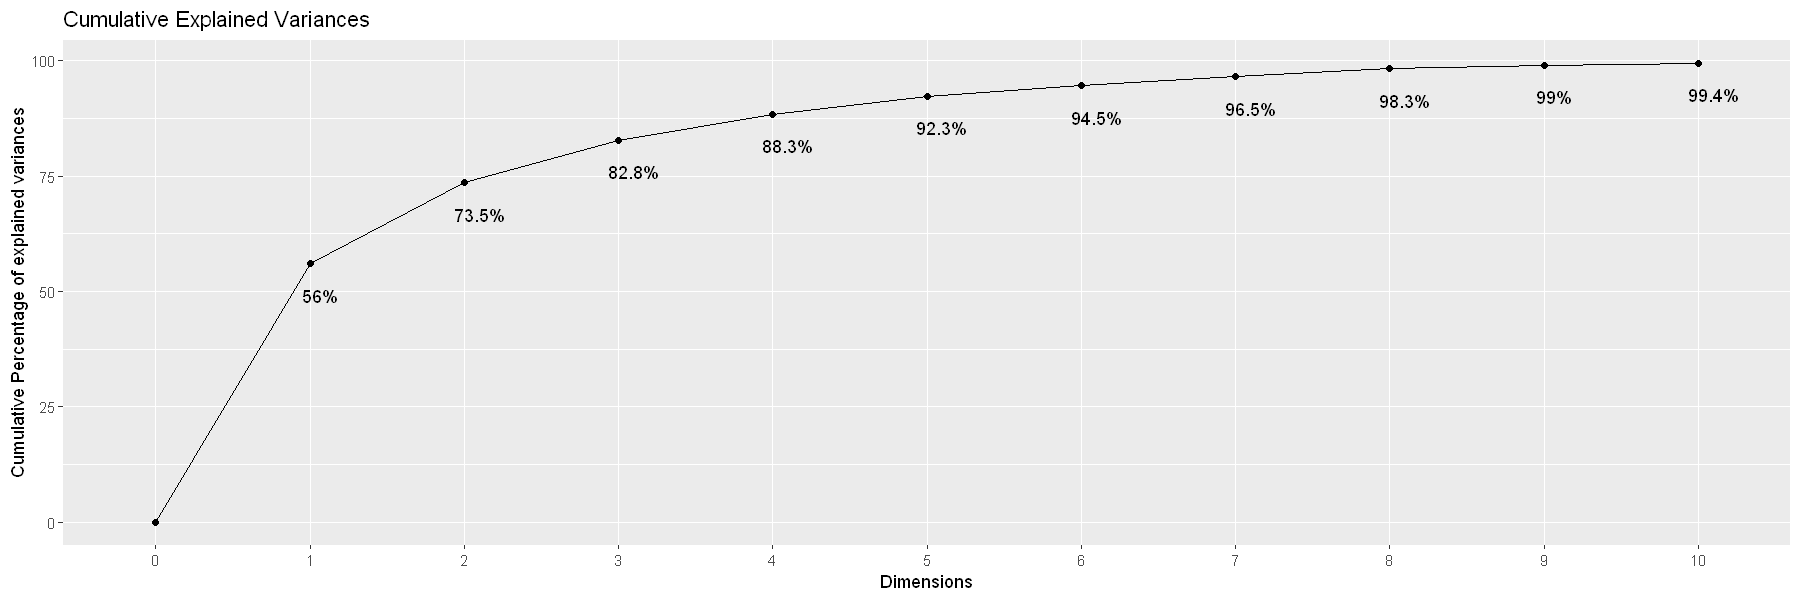

In [8]:
# resPC contains also the scree plot{scree.plot}, cumulative variance explained {CV.plot}, 
# the variables contribution of each component {contribCorr.plot()} and the quality of those 
# contributions {cos2Corr.plot()}.
options(repr.plot.width = 15, repr.plot.height = 5)
resPC$CV.plot

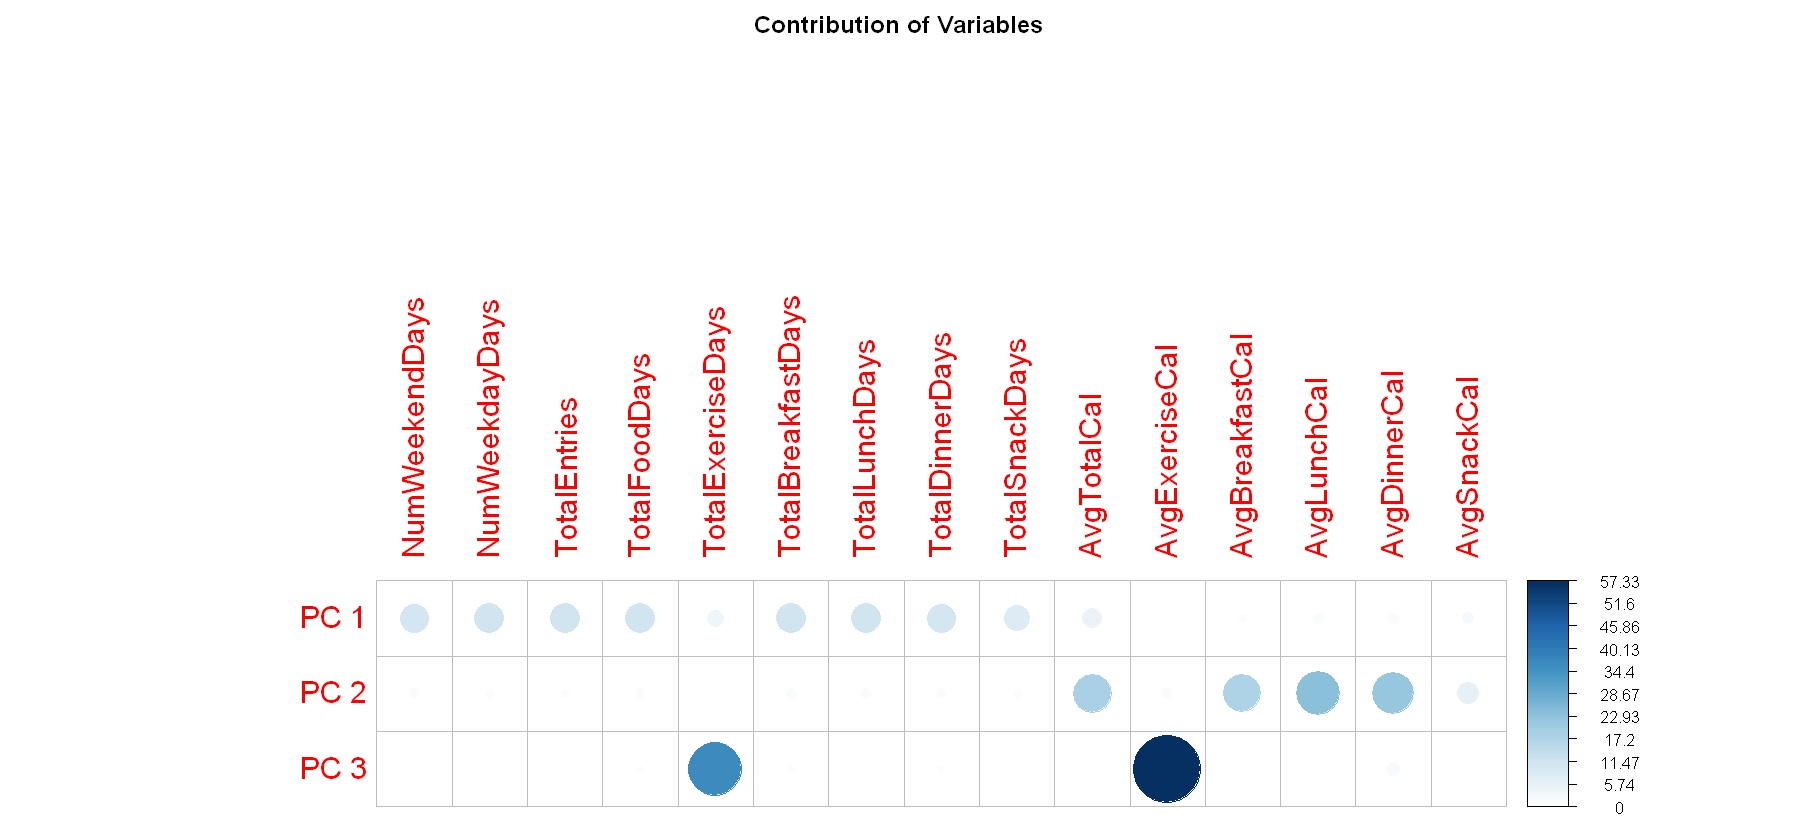

In [9]:
options(repr.plot.width = 15, repr.plot.height = 7)
resPC$contribCorr.plot(1.5) # to get numbers use resPC$contribCorrNum.plot()

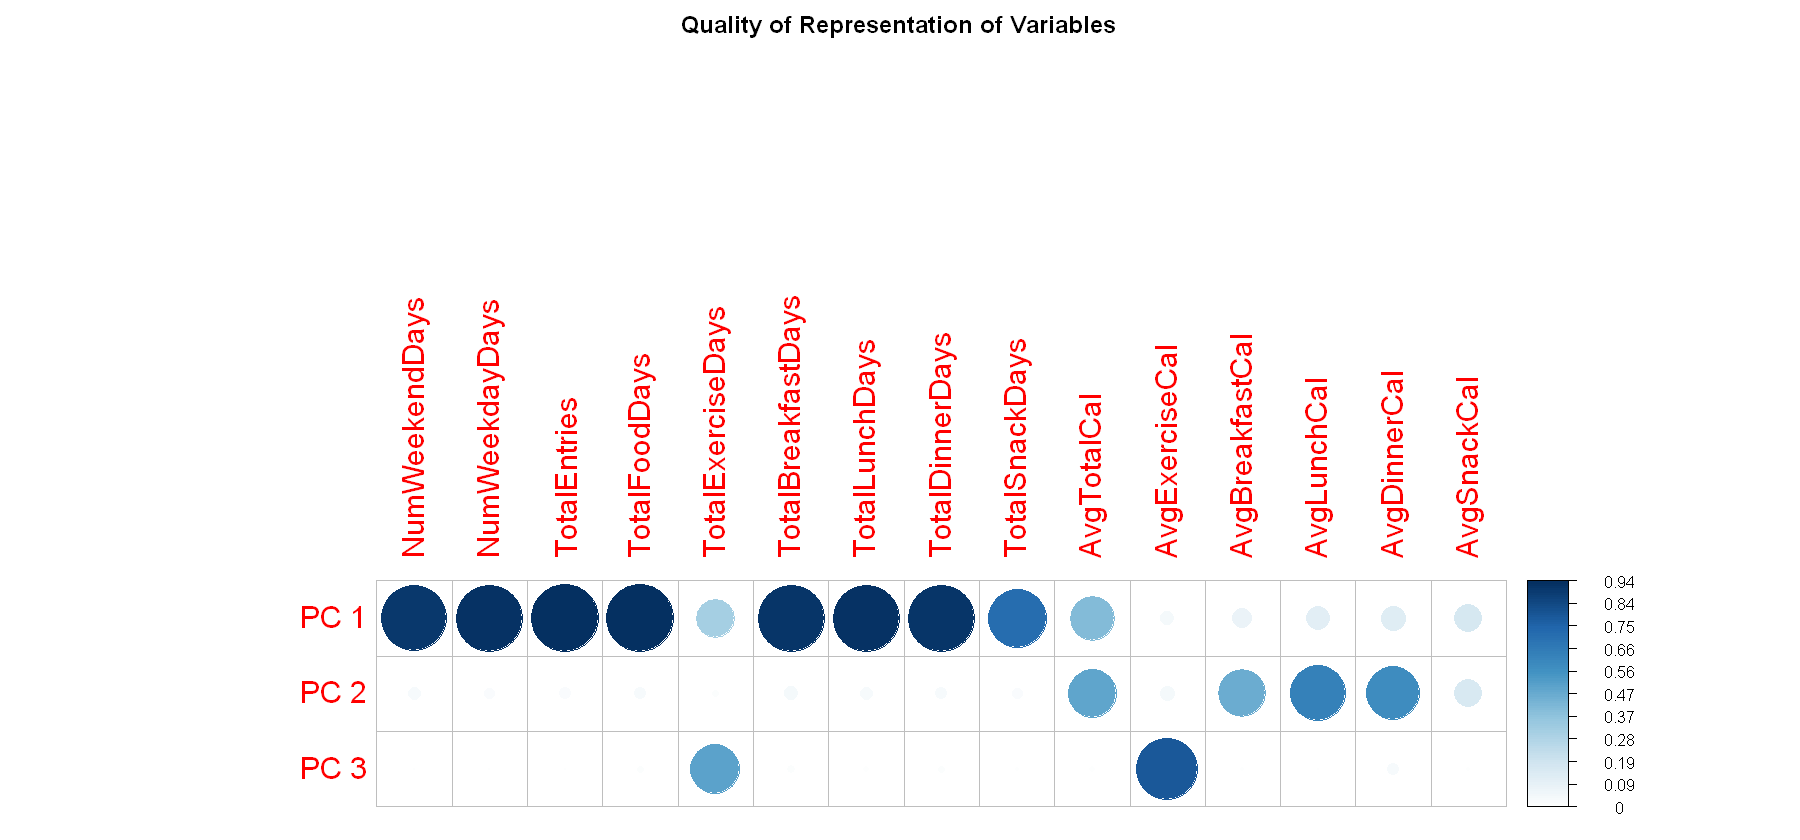

In [10]:
options(repr.plot.width = 15, repr.plot.height = 7)
resPC$cos2Corr.plot(1.5) # to get numbers use resPC$cos2CorrNum.plot()

---
## Analysis

The first step of the mediation analysis is to establish if our candidates variables are mediators or not.    
**To analyze the mediation we observe the following flowchart:**

![alt text](images/Mediation_flowchart.svg "Mediation Analysis flowchart")

**We first estimated two linear regressions for both the mediator and the outcome. We used also a permutation test to assess any associations with respect to our samples.**

**Clean the data:** *remove NA*

In [11]:
dat <- na.omit(dat)

---
### Relationship association assessment

We will consider the following assumptions:

* App usage and Number of self-weiging are casually unrelated mediators.
* Observed confounder is : age. 

#### **Regression of weight loss on the treatment.**

In [12]:
# Outcome model with confounders
out.fit <- lm(WeightLoss4Month ~ Treatment + Age, data = dat)
#  out.fit <- lm(WeightLoss12Month ~ Treatment + Age + Gender + logInitialWeight , data = dat)
summary(out.fit)


Call:
lm(formula = WeightLoss4Month ~ Treatment + Age, data = dat)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.073851 -0.025460 -0.004877  0.018164  0.177896 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0149407  0.0154585  -0.967    0.335    
Treatment    0.0340174  0.0065889   5.163 7.56e-07 ***
Age          0.0006692  0.0004350   1.538    0.126    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03969 on 151 degrees of freedom
Multiple R-squared:  0.1782,	Adjusted R-squared:  0.1673 
F-statistic: 16.37 on 2 and 151 DF,  p-value: 3.688e-07


#### **Permutation test: Weight loss ~ treatment assignment**

The mean weight loss for intervention is: 0.04334753 
The mean weight loss for no intervention is: 0.007583121 
The absolute t-test statistic is:  5.652639 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0 .


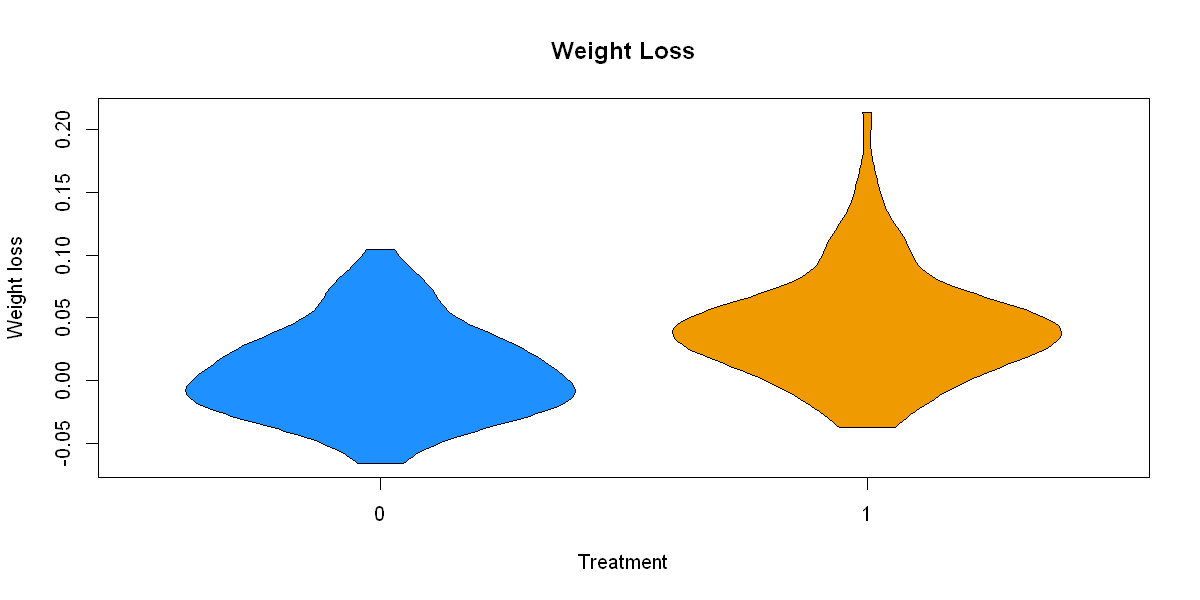

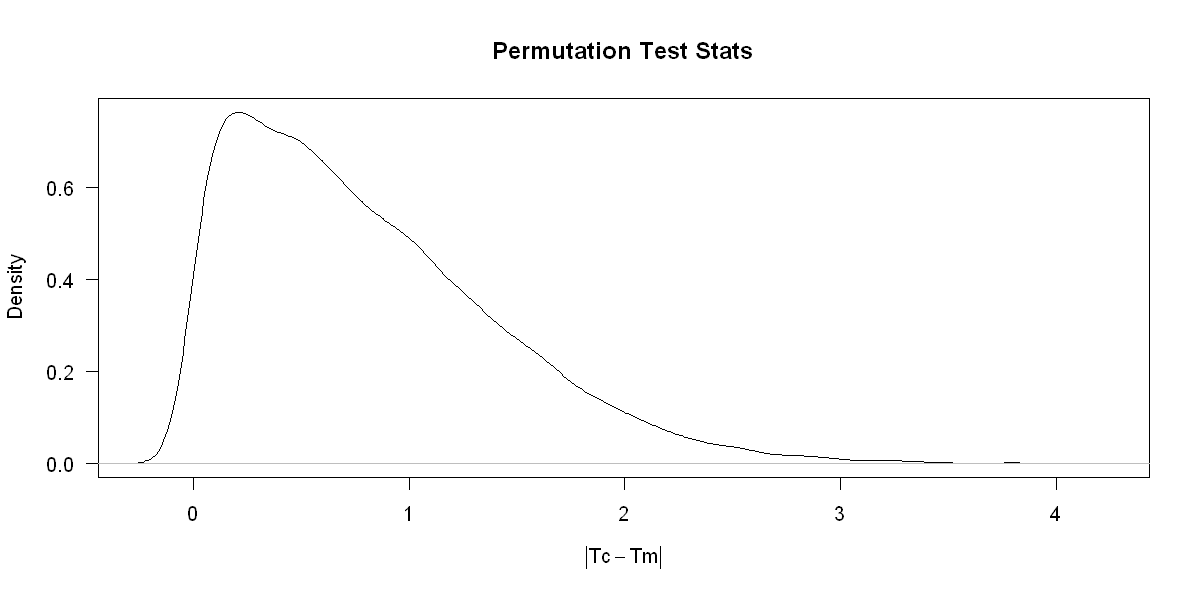

In [13]:
options(repr.plot.width = 10, repr.plot.height = 5)
getPermut(dat$WeightLoss4Month, dat$Treatment, P = 10000)

***We confirmed that the treatment has a statistically significant predictive capability on weight loss outcome.***

#### **Regression of App-usage (*i.e.*, PC1 ) on the treatment.**

In [14]:
# Outcome model with confounders
out.fit <- lm(App1 ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = App1 ~ Treatment + Age, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.6749 -1.1994  0.3201  1.4088  5.5347 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.61919    0.82396  -3.179  0.00179 ** 
Treatment    3.20550    0.35119   9.127 4.21e-16 ***
Age          0.03772    0.02319   1.627  0.10584    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.116 on 151 degrees of freedom
Multiple R-squared:  0.3833,	Adjusted R-squared:  0.3752 
F-statistic: 46.93 on 2 and 151 DF,  p-value: < 2.2e-16


#### **Permutation test: App-usage ~ treatment assignment**

The mean weight loss for intervention is: 1.95435 
The mean weight loss for no intervention is: -1.349618 
The absolute t-test statistic is:  9.026908 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0 .


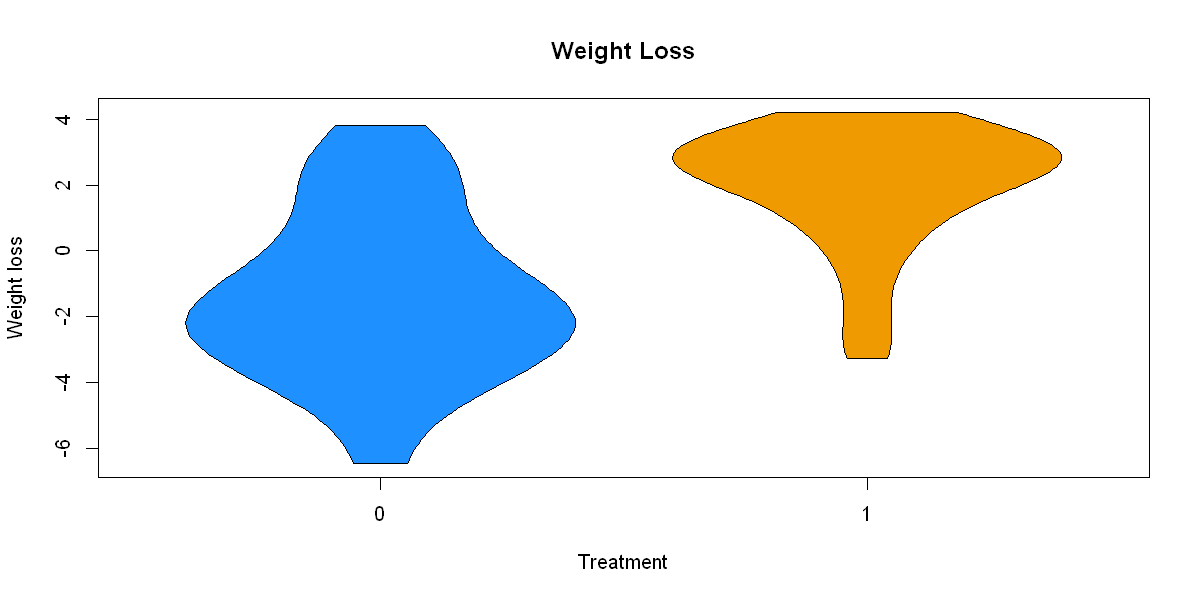

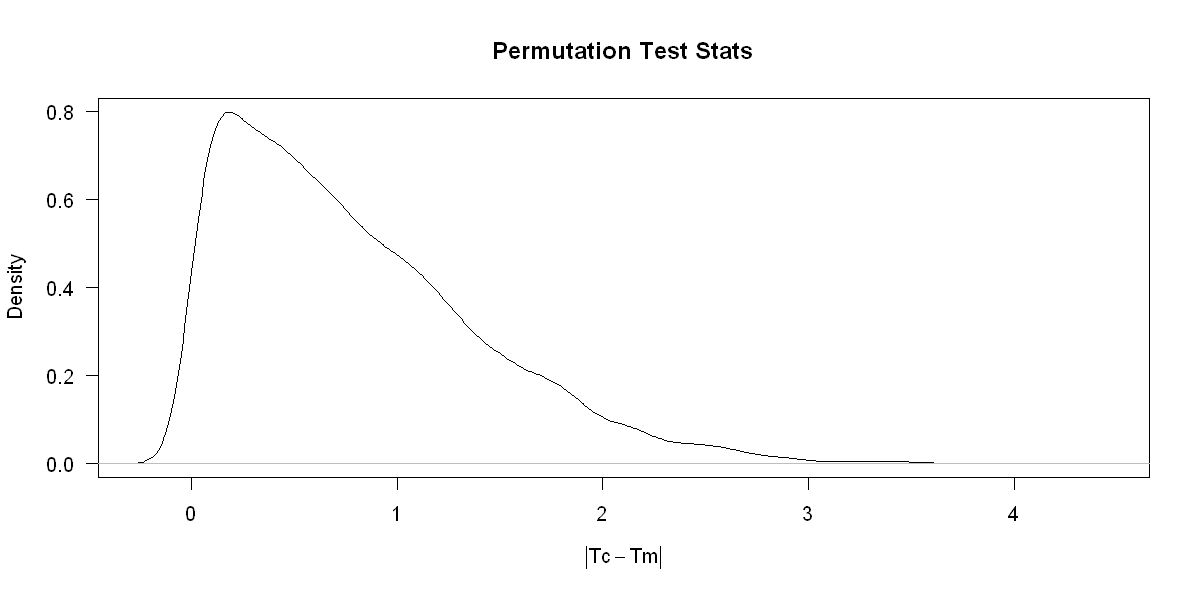

In [15]:
getPermut(dat$App1, dat$Treatment, P = 10000)

#### **Regression of App-calories (*i.e.*, PC2 ) on the treatment.**

In [16]:
# Outcome model with confounders
out.fit <- lm(App2 ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = App2 ~ Treatment + Age, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.0883 -0.8331 -0.0531  0.9237  5.0730 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.03453    0.57945  -1.785 0.076210 .  
Treatment    0.88649    0.24698   3.589 0.000447 ***
Age          0.01341    0.01631   0.822 0.412109    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.488 on 151 degrees of freedom
Multiple R-squared:  0.09049,	Adjusted R-squared:  0.07845 
F-statistic: 7.512 on 2 and 151 DF,  p-value: 0.0007761


#### **Permutation test: App-calories ~ treatment assignment**

The mean weight loss for intervention is: 0.3383369 
The mean weight loss for no intervention is: -0.5831633 
The absolute t-test statistic is:  3.593085 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 5e-04 .


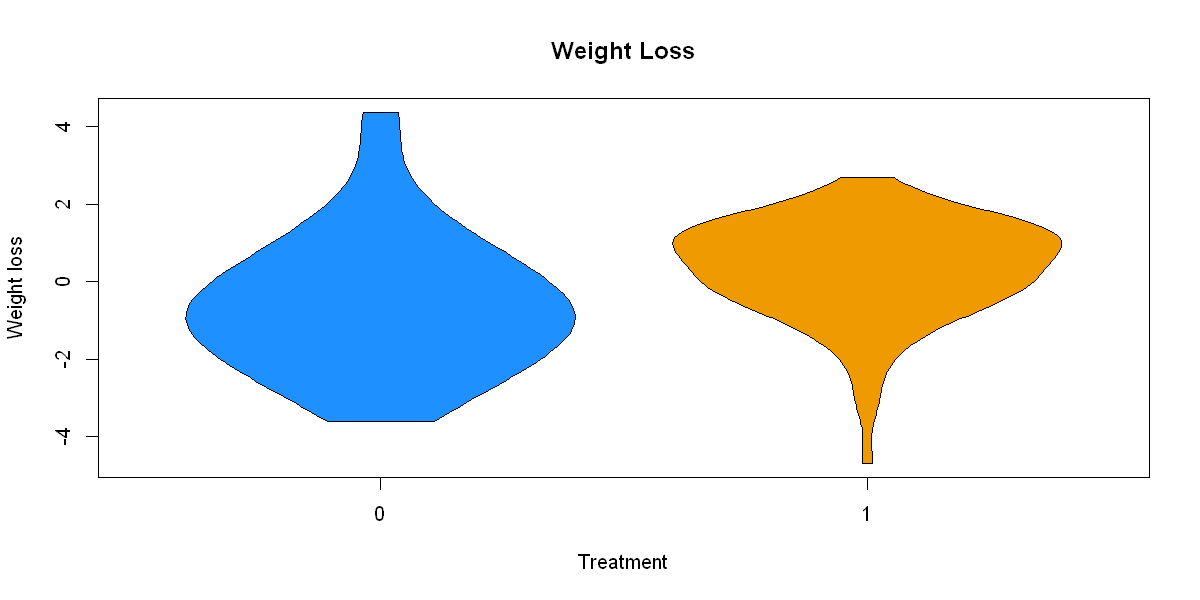

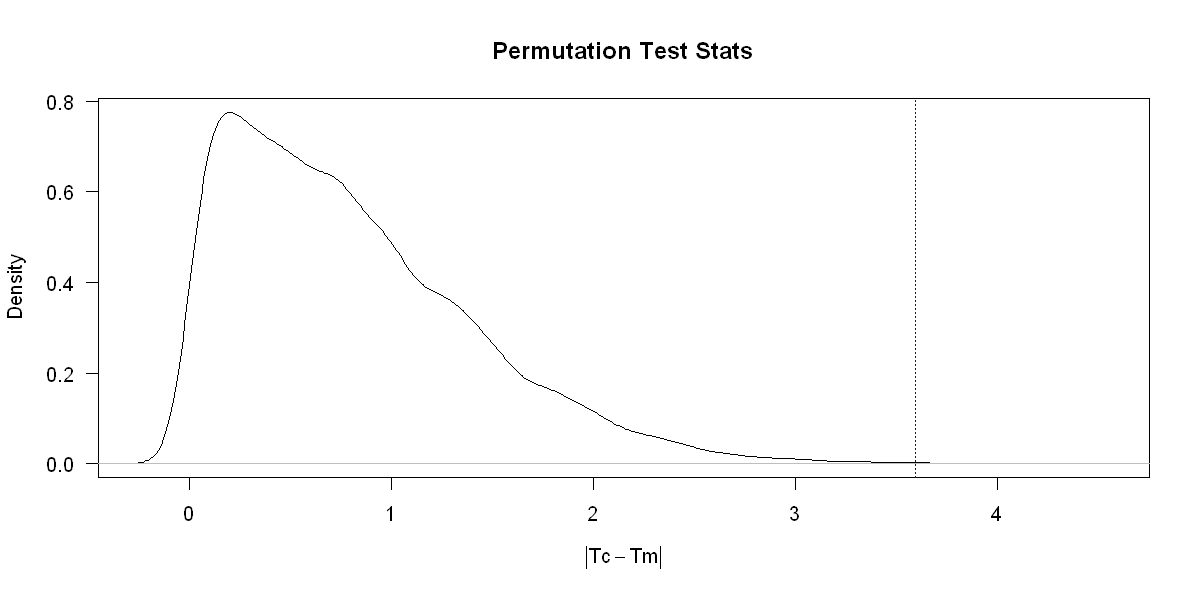

In [17]:
getPermut(dat$App2, dat$Treatment, P = 10000)

#### **Regression of App-exercise (*i.e.*, PC3 ) on the treatment.**

In [18]:
# Outcome model with confounders
out.fit <- lm(App3 ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = App3 ~ Treatment + Age, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1394 -1.0082  0.1198  0.9352  4.0383 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.806522   0.468278   1.722   0.0871 .
Treatment   -0.004417   0.199593  -0.022   0.9824  
Age         -0.024337   0.013177  -1.847   0.0667 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.202 on 151 degrees of freedom
Multiple R-squared:  0.02285,	Adjusted R-squared:  0.009903 
F-statistic: 1.765 on 2 and 151 DF,  p-value: 0.1747


#### **Permutation test: App-exercise ~ treatment assignment**

The mean weight loss for intervention is: -0.08051351 
The mean weight loss for no intervention is: -0.01256684 
The absolute t-test statistic is:  0.35562 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0.7293 .


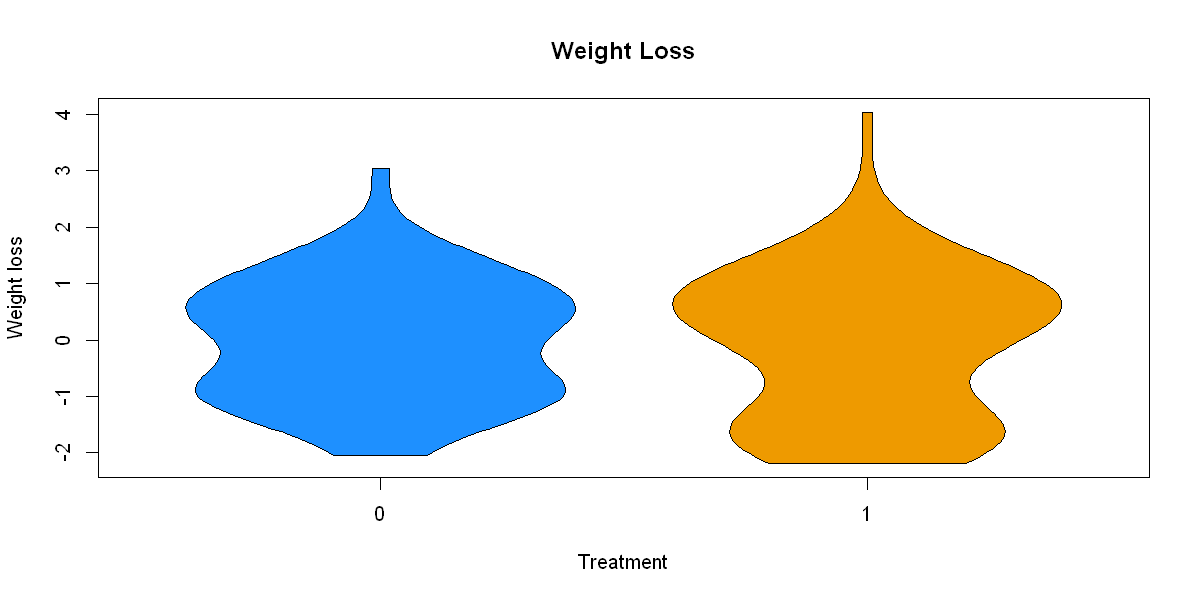

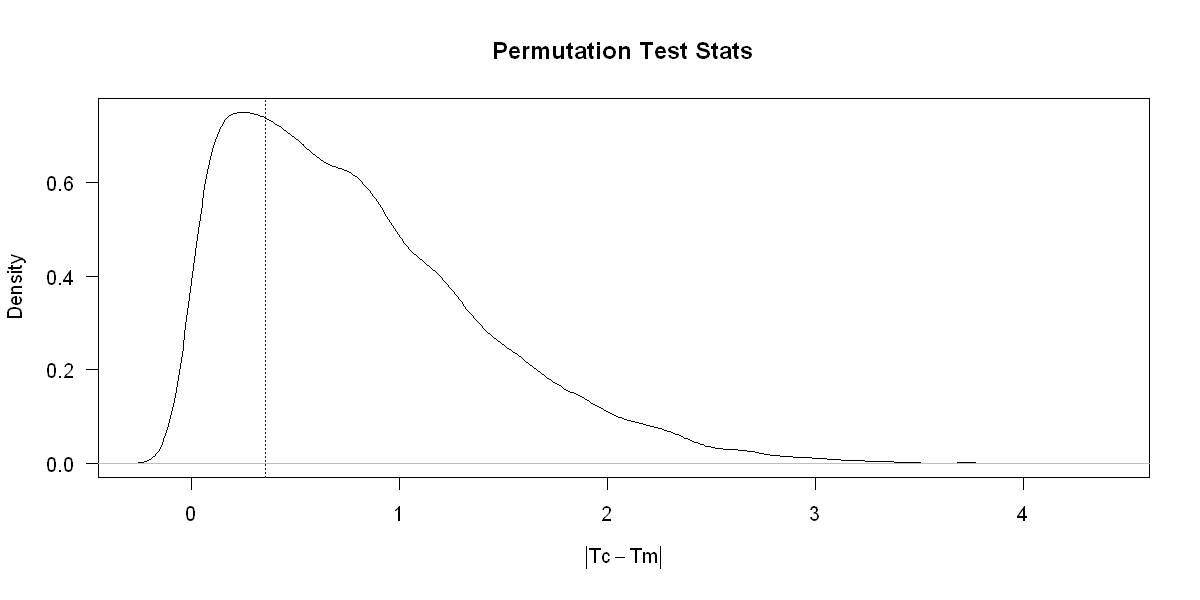

In [19]:
getPermut(dat$App3, dat$Treatment, P = 10000)

#### **Regression of Self-weight on the treatment.**

In [20]:
# Outcome model with confounders
out.fit <- lm(NumWeigh ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = NumWeigh ~ Treatment + Age, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-90.972 -17.877   3.454  21.050  62.872 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  45.9960    11.1490   4.126 6.09e-05 ***
Treatment    35.6398     4.7520   7.500 5.07e-12 ***
Age           0.3149     0.3137   1.004    0.317    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 28.63 on 151 degrees of freedom
Multiple R-squared:   0.29,	Adjusted R-squared:  0.2806 
F-statistic: 30.84 on 2 and 151 DF,  p-value: 5.874e-12


#### **Permutation test: Self-weight ~ treatment assignment**

The mean weight loss for intervention is: 93.05556 
The mean weight loss for no intervention is: 56.59375 
The absolute t-test statistic is:  7.562866 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0 .


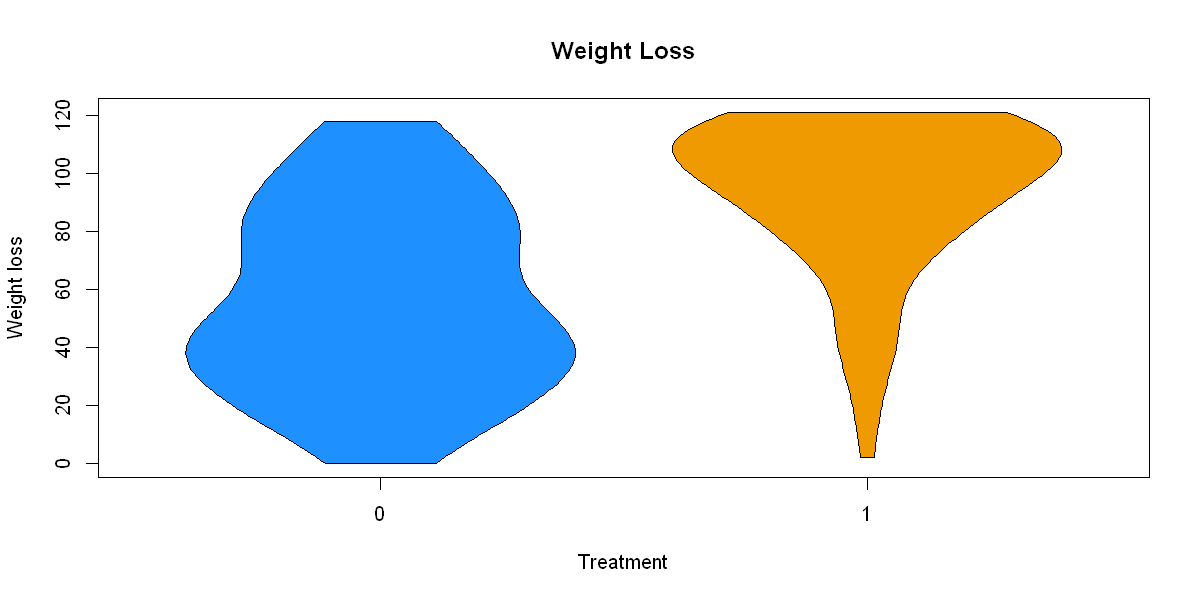

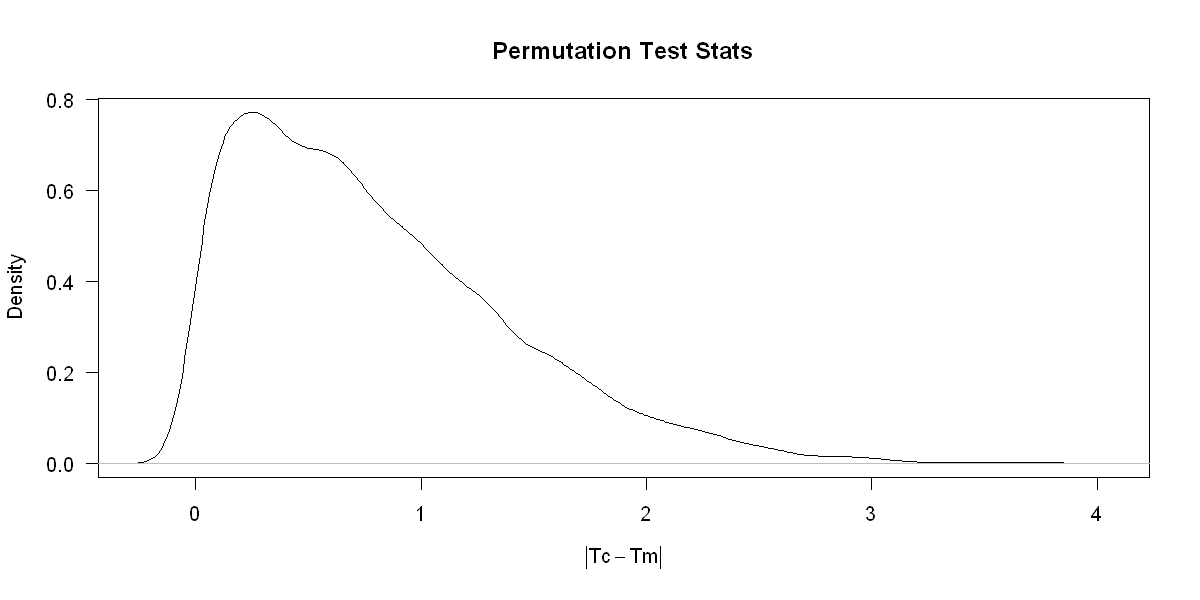

In [21]:
getPermut(dat$NumWeigh, dat$Treatment, P = 10000)

***We confirmed that the treatment has a statistically significant predictive capability on all potential mediators except for the app-exercise. Since app-usage variable (i.e., PC1) explained more than 55% of the variance, we considered only app-usage and self-weight variables for the mediation analysis for the 4 month-weight loss.***

---
## Mediation

**Our function `getMediationTable` to estimate the Average Causal Mediation Effect (ACME) and the Average Direct Effect (ADE) associated with each mediator is based on  the `mediation` library.**

In [22]:
numFile <- 1
rslts <- getMediationTable(dat, numFile, myBoot = TRUE, numSims = 10000, confLvl = 0.90) 
table1 <- rslts$med.tbl
table1

Running nonparametric bootstrap


Running nonparametric bootstrap




,Total Effect,Lower CI,Upper CI,ADE,Lower CI,Upper CI,ACME,Lower CI,Upper CI,Prop. Mediated
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
App-usage,0.034017,0.023507,0.044680,0.013491,0.001966,0.025446,0.020526,0.012366,0.029438,0.603409
Self-weight,0.034017,0.023285,0.045009,0.015019,0.004221,0.025880,0.018999,0.012270,0.026674,0.558506


### **Mediation Results** 


In [63]:
rslts$med.tbl %>%
  kable("html") %>% 
  column_spec(c(1), bold = T, color = "black") %>%
  column_spec(c(2, 5, 8), bold = T, color = "steelblue") %>%
  column_spec(c(3, 4, 6, 7, 9, 10), bold = T, color = "sienna") %>%
  column_spec(c(11), bold = T, color = "black")%>%
  as.character() %>%
  display_html()

,Total Effect,Lower CI,Upper CI,ADE,Lower CI,Upper CI,ACME,Lower CI,Upper CI,Prop. Mediated
App-usage,0.034017,0.023507,0.044680,0.013491,0.001966,0.025446,0.020526,0.012366,0.029438,0.603409
Self-weight,0.034017,0.023285,0.045009,0.015019,0.004221,0.025880,0.018999,0.012270,0.026674,0.558506


In [68]:
kable(rslts$med.tbl, booktabs = T) %>%
  as.character() %>%
  display_html()

,Total Effect,Lower CI,Upper CI,ADE,Lower CI,Upper CI,ACME,Lower CI,Upper CI,Prop. Mediated
App-usage,0.034017,0.023507,0.044680,0.013491,0.001966,0.025446,0.020526,0.012366,0.029438,0.603409
Self-weight,0.034017,0.023285,0.045009,0.015019,0.004221,0.025880,0.018999,0.012270,0.026674,0.558506


In [69]:
rslts$med.tbl %>%
  kable("html") %>% 
  column_spec(c(1), bold = T, color = "black") %>%
  column_spec(c(2, 5, 8), bold = T, color = "steelblue") %>%
  column_spec(c(3, 4, 6, 7, 9, 10), bold = T, color = "sienna") %>%
  column_spec(c(11), bold = T, color = "black")

<table>
 <thead>
  <tr>
   <th style="text-align:left;">   </th>
   <th style="text-align:right;"> Total Effect </th>
   <th style="text-align:right;"> Lower CI </th>
   <th style="text-align:right;"> Upper CI </th>
   <th style="text-align:right;"> ADE </th>
   <th style="text-align:right;"> Lower CI </th>
   <th style="text-align:right;"> Upper CI </th>
   <th style="text-align:right;"> ACME </th>
   <th style="text-align:right;"> Lower CI </th>
   <th style="text-align:right;"> Upper CI </th>
   <th style="text-align:right;"> Prop. Mediated </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;font-weight: bold;color: black !important;"> App-usage </td>
   <td style="text-align:right;font-weight: bold;color: steelblue !important;"> 0.034017 </td>
   <td style="text-align:right;font-weight: bold;color: sienna !important;"> 0.023507 </td>
   <td style="text-align:right;font-weight: bold;color: sienna !important;"> 0.044680 </td>
   <td style="text-align:right;font-weigh

---
## Sensitivity Analysis

In [25]:
sensApp.out <- medsens(rslts$med.rslts$medApp.out, rho.by = 0.01, effect.type = "indirect", sims = 10000)
sensNumW.out <- medsens(rslts$med.rslts$medNumW.out, rho.by = 0.01, effect.type = "indirect", sims = 10000)

### App-usage

#### Results

In [26]:
summary(sensApp.out)


Mediation Sensitivity Analysis for Average Causal Mediation Effect

Sensitivity Region

       Rho    ACME 90% CI Lower 90% CI Upper R^2_M*R^2_Y* R^2_M~R^2_Y~
 [1,] 0.23  0.0072      -0.0005       0.0148       0.0529       0.0237
 [2,] 0.24  0.0066      -0.0011       0.0142       0.0576       0.0258
 [3,] 0.25  0.0059      -0.0017       0.0135       0.0625       0.0280
 [4,] 0.26  0.0053      -0.0023       0.0129       0.0676       0.0303
 [5,] 0.27  0.0047      -0.0029       0.0122       0.0729       0.0326
 [6,] 0.28  0.0040      -0.0035       0.0116       0.0784       0.0351
 [7,] 0.29  0.0034      -0.0041       0.0109       0.0841       0.0377
 [8,] 0.30  0.0028      -0.0048       0.0103       0.0900       0.0403
 [9,] 0.31  0.0021      -0.0054       0.0096       0.0961       0.0430
[10,] 0.32  0.0014      -0.0061       0.0090       0.1024       0.0459
[11,] 0.33  0.0008      -0.0068       0.0083       0.1089       0.0488
[12,] 0.34  0.0001      -0.0074       0.0076       0.1156  

#### Sensitivity with respect to error correlation

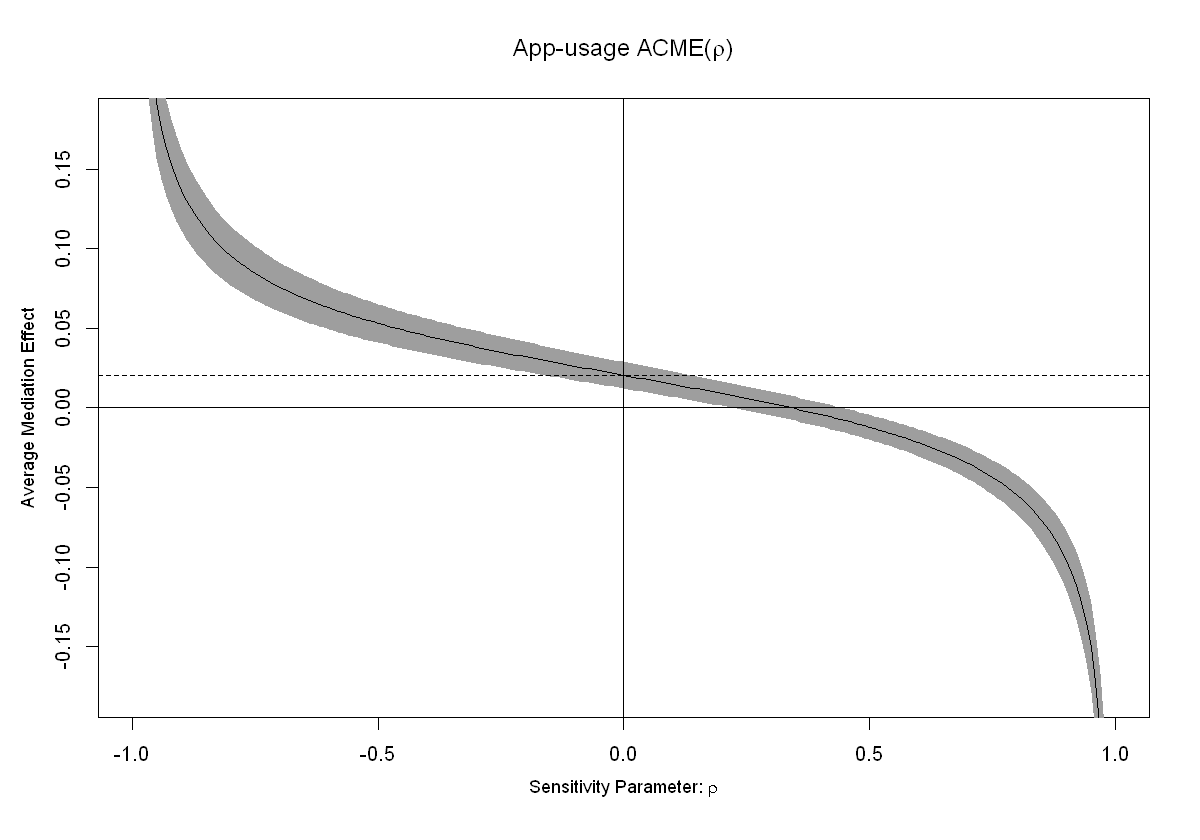

In [27]:
options(repr.plot.width = 10, repr.plot.height = 7)
plot(sensApp.out,  ylim = c(-0.18, 0.18), main  =  expression(paste("App-usage ACME(", rho, ")")))

The above figure shows the estimated true values of ACMEs as functions of the sensitivity parameter $\rho$, which
represents the correlation between the error terms in the mediator and the outcome models. The thick lines
and gray bands represent the point estimates of the ACME and their 90% confidence intervals, respectively.   
According to this analysis, the ACME is estimated to be negative when the correlation between the error terms in the mediator
and the outcome models is larger than 0.34, and the ACME is statistically indistinguishable from
zero at the 90% level when the parameter $\rho$ is >0.23.

#### Sensitivity with respect to proportion of variance explained

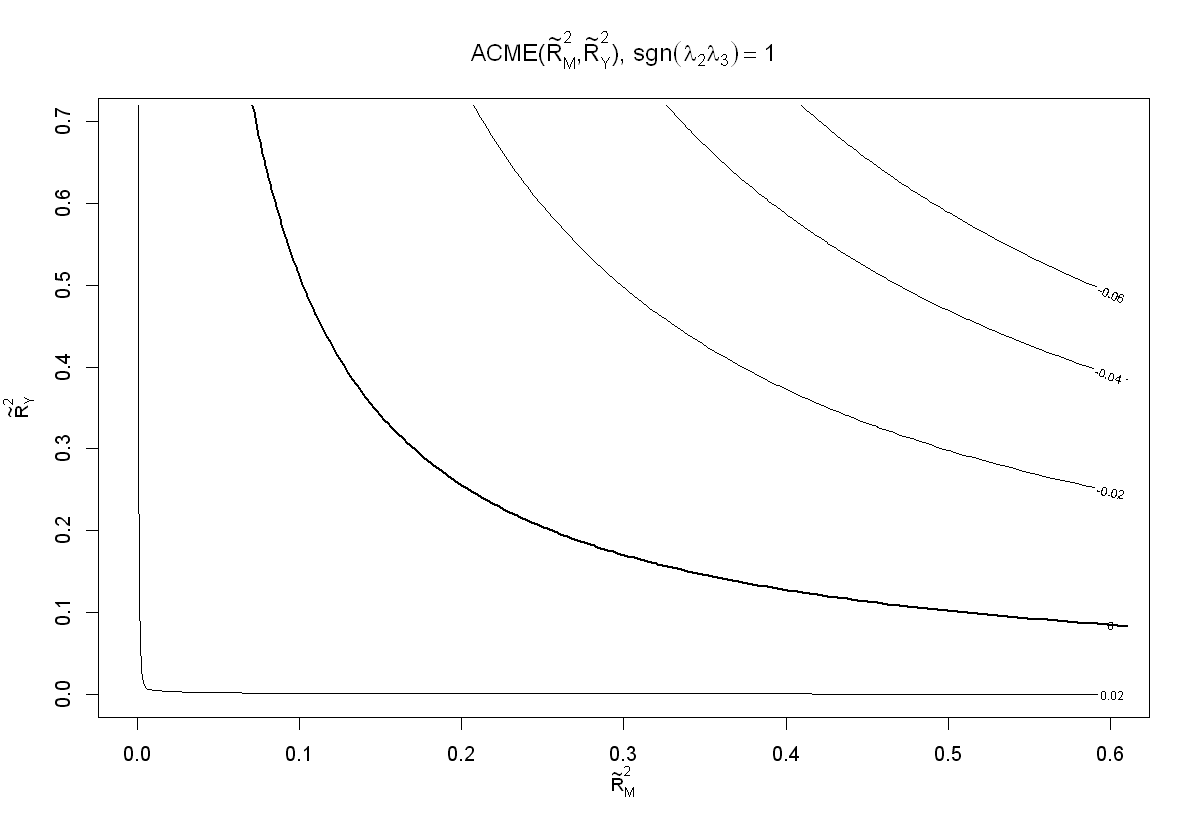

In [28]:
plot(sensApp.out, sens.par = "R2", r.type = "total", sign.prod = "positive",
     xlim = c(-0.0, 0.6), ylim = c(-0.0, 0.7))

In the sensitivity analyses plot above, the ACME estimates are plotted against $\tilde{R}^2_Y \tilde{R}^2_M$, the proportions of the total variance in the outcome and mediator variables, respectively, that would be explained by a hypothetical unobserved pretreatment confounder.
In terms of the coefficient of determination parameters, the product of $\tilde{R}^2_M$ and $\tilde{R}^2_Y$ must be at least as large
as 0.0518, implying that an unobserved pretreatment confounder must explain 20% of the variation in the participants’ app-usage and 25.6% of the variation in their weight loss, for example.

We find that the true ACME changes sign if the product of the total variance in weight loss explained by an unmeasured confounder, $\tilde{R}^2_Y$,  times the total variance in app usage explained by an unmeasured confounder, $\tilde{R}^2_M$, is greater than 0.0518, and the confounder affects both mediator and outcome in the same direction.   
The positive ACME in the analysis is robust to confounding because the unobserved confounder (UC) when the latter explains less than about 19.18% of the variance in the mediator and outcome. In other words, UC would explain only 19.18% of the variance in the mediator and out come in the case where the mediated effect is vanished.


### Self-weight

#### Results

In [29]:
summary(sensNumW.out)


Mediation Sensitivity Analysis for Average Causal Mediation Effect

Sensitivity Region

       Rho    ACME 90% CI Lower 90% CI Upper R^2_M*R^2_Y* R^2_M~R^2_Y~
 [1,] 0.27  0.0062       0.0000       0.0124       0.0729       0.0362
 [2,] 0.28  0.0057      -0.0005       0.0119       0.0784       0.0390
 [3,] 0.29  0.0052      -0.0010       0.0113       0.0841       0.0418
 [4,] 0.30  0.0047      -0.0015       0.0108       0.0900       0.0448
 [5,] 0.31  0.0041      -0.0020       0.0103       0.0961       0.0478
 [6,] 0.32  0.0036      -0.0025       0.0097       0.1024       0.0509
 [7,] 0.33  0.0031      -0.0030       0.0092       0.1089       0.0541
 [8,] 0.34  0.0025      -0.0036       0.0086       0.1156       0.0575
 [9,] 0.35  0.0020      -0.0041       0.0080       0.1225       0.0609
[10,] 0.36  0.0014      -0.0047       0.0075       0.1296       0.0644
[11,] 0.37  0.0008      -0.0052       0.0069       0.1369       0.0681
[12,] 0.38  0.0003      -0.0058       0.0063       0.1444  

#### Sensitivity with respect to error correlation

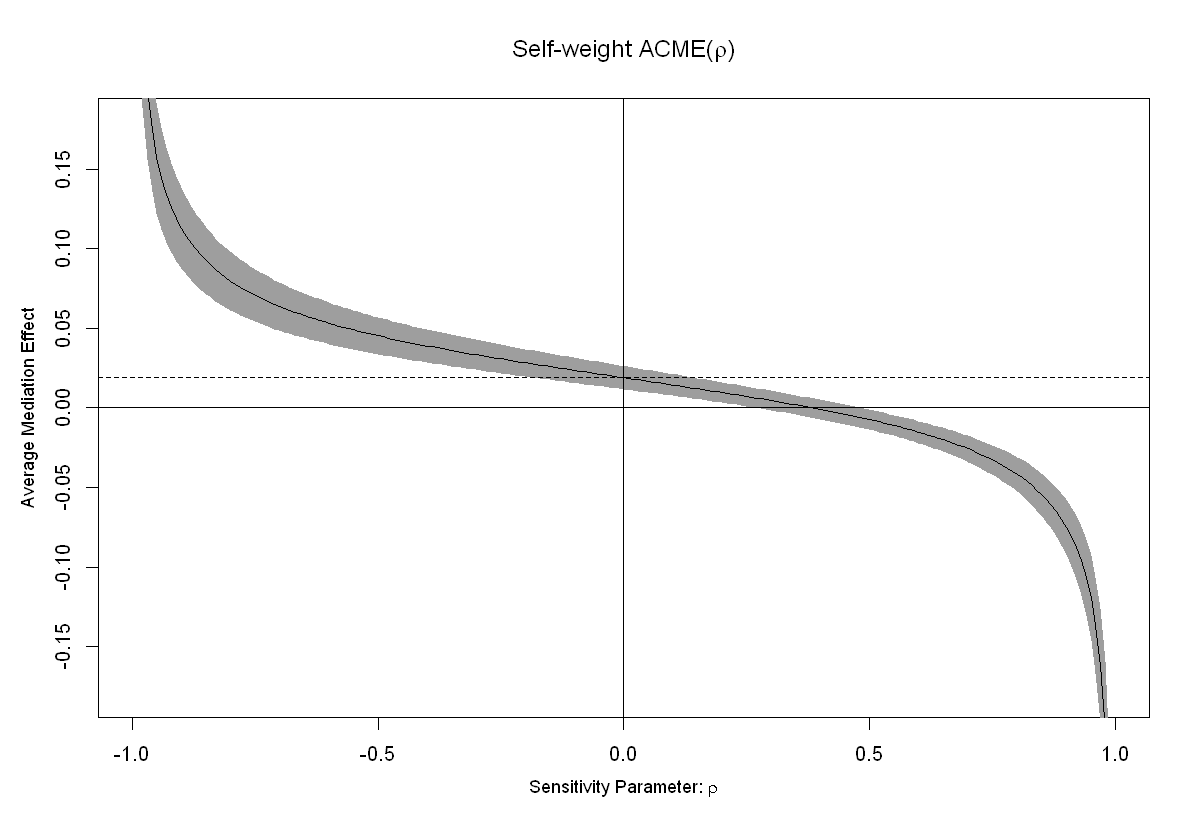

In [30]:
plot(sensNumW.out,  ylim = c(-0.18, 0.18), main  =  expression(paste("Self-weight ACME(", rho, ")")))

The above figure shows the estimated true values of ACMEs as functions of the sensitivity parameter $\rho$, which
represents the correlation between the error terms in the mediator and the outcome models. The thick lines
and gray bands represent the point estimates of the ACME and their 90% confidence intervals, respectively.   
According to this analysis, the ACME is estimated to be negative when the correlation between the error terms in the mediator
and the outcome models is larger than 0.38, and the ACME is statistically indistinguishable from
zero at the 90% level when the parameter $\rho$ is >0.27.

### Sensitivity with respect to proportion of variance explained

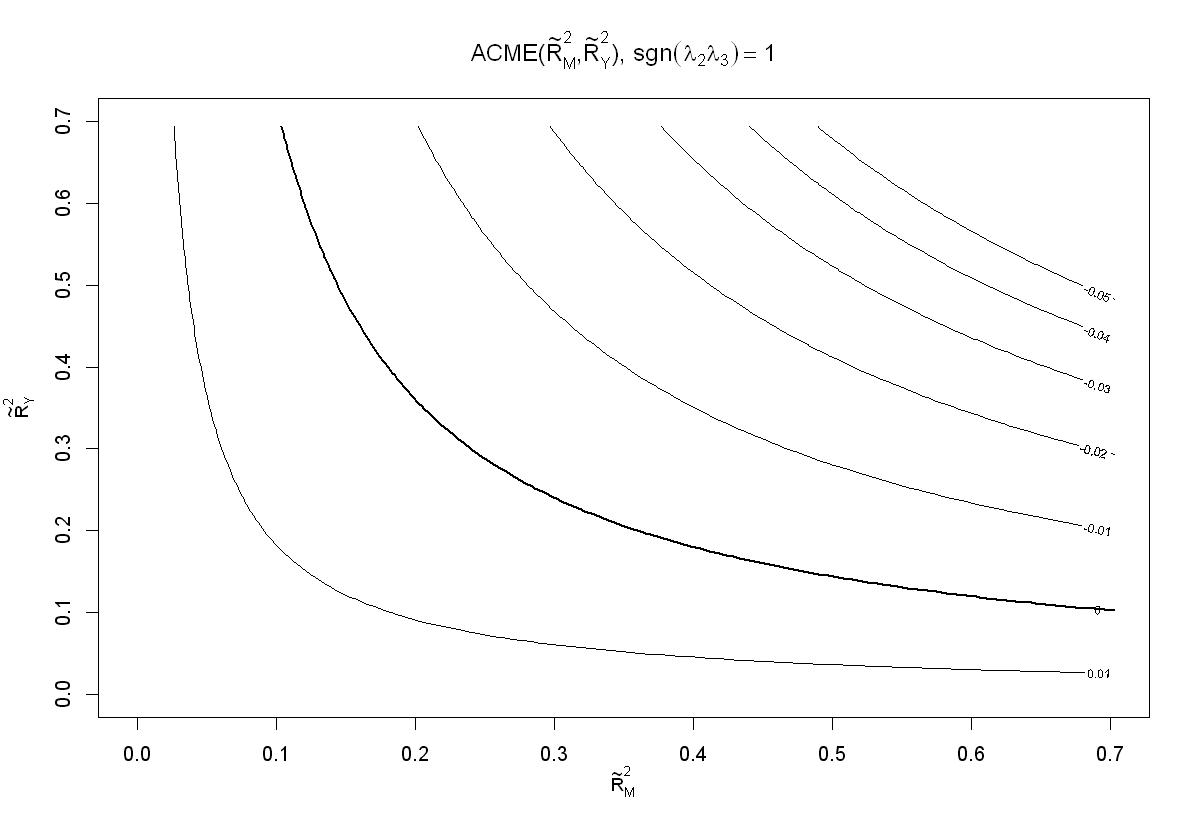

In [31]:
plot(sensNumW.out, sens.par = "R2", r.type = "total", sign.prod = "positive",
     xlim = c(-0.0, 0.7), ylim = c(-0.0, 0.7))

In the sensitivity analyses plot above, the ACME estimates are plotted against $\tilde{R}^2_Y \tilde{R}^2_M$, the proportions of the total variance in the outcome and mediator variables, respectively, that would be explained by a hypothetical unobserved pretreatment confounder.
In terms of the coefficient of determination parameters, the product of $\tilde{R}^2_M$ and $\tilde{R}^2_Y$ must be at least as large
as 0.0718, implying that an unobserved pretreatment confounder must explain 20% of the variation in the participants’ app-usage and 35.9% of the variation in their weight loss, for example.

## Conclusion

Overall, the results suggest that under the assumption of independence between mechanisms, the causal mediation effects are positive and
moderately statistically significant in all of the three studies, and the estimates are fairly robust to the
possible unobserved pretreatment mediator–outcome confounding to varying degrees.